In [2]:
from __future__ import print_function

import csv
import codecs
import sys
import string
import time
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from random import shuffle 
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.classify import SklearnClassifier
from nltk.util import ngrams
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA, FastICA
from sklearn import preprocessing


def loadData(path, rawX, rawY):
    with open(path) as f:
        reader = csv.reader(f)
        next(reader)
        for line in reader:
            data = [int(x)*1.0/255 for x in line[1:]]
            rawX.append(data)
            rawY.append(int(line[0]))




[nltk_data] Downloading package punkt to /home/junyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/junyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/junyi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
X, Y = [], []
loadData('digits.csv', X, Y)
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(42000, 784)
(42000,)


In [4]:
print(X[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
starttime = time.time()
reduced_data = PCA(n_components=2).fit_transform(X)
reduced_data = preprocessing.scale(reduced_data)
print("PCA time is ", time.time()-starttime)

PCA time is  2.43763995171


In [166]:
print(reduced_data.shape)

(1500, 4)


In [22]:
newdata = []
for i in xrange(reduced_data.shape[0]):
    newdata.append(np.append(reduced_data[i], support[i]))
newdata = np.array(newdata)
newdata = preprocessing.scale(newdata)
print(newdata.shape)
print(newdata[:10])

(3997, 5)
[[-0.25651867  0.82786406  0.03996701  0.94236358  0.31669576]
 [-0.19262389  0.7176877  -0.29219901  0.94236358 -0.44310793]
 [ 1.00565194  0.13687705  0.41958531  0.94236358  0.31669576]
 [-0.27975488  0.07354266 -0.41082973 -1.06116155 -1.96271531]
 [-0.22270058  0.47447769 -0.07866371 -1.06116155 -0.44310793]
 [-0.12655774  0.20163567  0.51448988  0.94236358 -1.96271531]
 [-0.44114718 -3.24841819  1.32117878  0.94236358  1.07649945]
 [-0.259143   -0.21125722 -0.14984214  0.94236358 -1.96271531]
 [-0.17389772 -0.40818733 -0.5057343   0.94236358  1.07649945]
 [-0.28139631  0.25554479 -0.48200816 -1.06116155  0.31669576]]


In [7]:
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

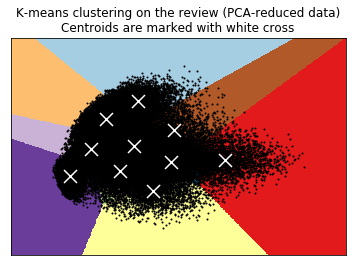

<Figure size 432x288 with 0 Axes>

In [8]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the review (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
fig = plt.gcf()
fig.savefig('PCA_digits')

In [163]:
predict = kmeans.labels_.astype(np.int)
precision, recall, _, _ = precision_recall_fscore_support(Y, predict, average = 'micro')
print(precision, recall)

ValueError: Found input variables with inconsistent numbers of samples: [3997, 1500]

Evaluate of KMeans with k-means++ init
running time is 161.797818899 s


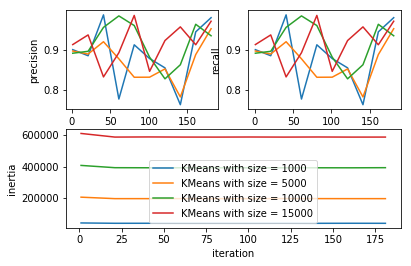

In [4]:
clusters = [
               (KMeans, 'k-means++', {}),             
           ]
sample_size = [1000, 5000, 10000, 15000]
max_iters = xrange(1, 200, 20)
clf_error = {}
plt.figure()
ax1 = plt.subplot(212)
ax2 = plt.subplot(221)
ax3 = plt.subplot(222)
legends = []
starttime = time.time()
for factory, init, params in clusters:
    print('Evaluate of {} with {} init'.format(factory.__name__, init))
    for size in sample_size:
        precisions = np.empty(len(max_iters))
        recalls = np.empty(len(max_iters))
        inertia = np.empty(len(max_iters))
        for i, max_iter in enumerate(max_iters):
            #change fit(newdata[:size]) to use PCA
            #change to fit(X[:size]) to use kmeans without reduction
            km = factory(n_clusters=10, max_iter=max_iter, n_init=5, **params).fit(X[:size])
            predict = km.labels_.astype(np.int)
            precision, recall, _, _ = precision_recall_fscore_support(Y[:size], predict, average = 'micro')
            #print(precision, recall)
            inertia[i] = km.inertia_
            precisions[i] = max(precision, 1 - precision)
            recalls[i] = max(recall, 1 - recall)
        ax1.plot(max_iters, inertia)
        ax2.plot(max_iters, precisions)
        ax3.plot(max_iters, recalls)
        legends.append("{} with size = {}".format(factory.__name__, size))
    fig = plt.gcf()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('inertia')
    ax1.legend(legends)

    ax2.set_ylabel('precision')
    ax3.set_ylabel('recall')
    fig.savefig('PCA_digits')
print('running time is {} s'.format(time.time()-starttime))